# **Neural Machine Translation**
### Deep Learning Project

> ## ***Model 3: Basic RNN Network***
> ## **RNN+LSTM**

### **Preprocessing Pipeline:**
1. Load & examine the data.
2. Cleaning the data. 
  * Converting the data into an array for easy implementation.
  * Reducing the size of dataset to save the computation cost.(Only in this case)
  * Removing irrelevant text like attribution details
  * Splitting each sample/text into English-German pairs.
  * Removing punctuations.
  * Converting the text to lower case.
3. Tokenizing & vectorizing the text into numerical sequences.
4. Padding those sequences with 0’s to bring them to same length.

In [ ]:
# For the Preprocessing
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For converting data into a form to be loaded into model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# For building the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, RepeatVector
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers

In [ ]:
print(keras.__version__)

2.9.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import random
data_path = "/content/drive/MyDrive/Colab Notebooks/DLProject/NMT_EngToHindi/English.txt"
data_path2 = "/content/drive/MyDrive/Colab Notebooks/DLProject/NMT_EngToHindi/Hindi.txt"
# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
  lines = f.read().strip().split('\n')
with open(data_path2, 'r', encoding='utf-8') as f:
  lines2 = f.read().strip().split('\n')

lines = [" ".join(re.findall(r"[A-Za-z0-9]+",line)) for line in lines]
lines2 = [re.sub(r"%s|\(|\)|<|>|%|[a-z]|[A-Z]|_",'',line) for line in lines2]

# Grouping lines by response pair
pairs = list(zip(lines,lines2))
random.shuffle(pairs)
print(len(pairs))

6000


In [ ]:
print(pairs[103])

('they might go to new jersey next fall', 'वे अगली गिरावट के लिए नई जर्सी में जा सकते हैं।')


In [ ]:
import numpy as np

input_docs = []
target_docs = []
input_tokens = set()
target_tokens = set()
for line in pairs:
  input_doc, target_doc = line[0], line[1]
  # Appending each input sentence to input_docs
  input_docs.append(input_doc)
  # Splitting words from punctuation  
  target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
  # Redefine target_doc below and append it to target_docs
  target_doc = '<START> ' + target_doc + ' <END>'
  target_docs.append(target_doc)
  
  # Now we split up each sentence into words and add each unique word to our vocabulary set
  for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    if token not in input_tokens:
      input_tokens.add(token)
  for token in target_doc.split(" "):
    if token not in target_tokens:
      target_tokens.add(token)
input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))
num_encoder_tokens = len(input_tokens)
num_decoder_tokens = len(target_tokens)

input_features_dict = dict(
    [(token, i) for i, token in enumerate(input_tokens)])
target_features_dict = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_input_features_dict = dict(
    (i, token) for token, i in input_features_dict.items())
reverse_target_features_dict = dict(
    (i, token) for token, i in target_features_dict.items())


max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

encoder_input_data = np.zeros(
    (len(input_docs), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_docs), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        #Assign 1. for the current line, timestep, & word in encoder_input_data
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.
    
    for timestep, token in enumerate(target_doc.split()):
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.


In [ ]:
print(target_docs[103],input_docs[103],num_decoder_tokens,num_encoder_tokens)

<START> व े अगल ी ग ि र ा वट क े ल ि ए नई जर ् स ी म े ं ज ा सकत े ह ै ं । <END> they might go to new jersey next fall 219 196


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras import callbacks
from keras.callbacks import Callback
#Dimensionality
dimensionality = 256
#The batch size and number of epochs
batch_size = 256
epochs = 100
#Encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(dimensionality, return_state=True)
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]
#Decoder
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(dimensionality, return_sequences=True, return_state=True)
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# #Model
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# #Compiling
training_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Training
history = training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split=0.2)
#training_model.save('training_model.h5')

Epoch 1/100
19/19 [==============================] - 10s 116ms/step - loss: 2.5646 - accuracy: 0.0426 - val_loss: 2.2087 - val_accuracy: 0.0427
Epoch 2/100
19/19 [==============================] - 1s 55ms/step - loss: 2.1848 - accuracy: 0.0444 - val_loss: 2.1509 - val_accuracy: 0.0445
Epoch 3/100
19/19 [==============================] - 1s 64ms/step - loss: 2.1698 - accuracy: 0.0410 - val_loss: 2.1442 - val_accuracy: 0.0393
Epoch 4/100
19/19 [==============================] - 1s 74ms/step - loss: 2.1590 - accuracy: 0.0394 - val_loss: 2.1357 - val_accuracy: 0.0405
Epoch 5/100
19/19 [==============================] - 1s 72ms/step - loss: 2.1487 - accuracy: 0.0406 - val_loss: 2.1272 - val_accuracy: 0.0421
Epoch 6/100
19/19 [==============================] - 1s 72ms/step - loss: 2.1417 - accuracy: 0.0436 - val_loss: 2.1188 - val_accuracy: 0.0444
Epoch 7/100
19/19 [==============================] - 1s 67ms/step - loss: 2.1330 - accuracy: 0.0460 - val_loss: 2.1093 - val_accuracy: 0.0448
Epoc

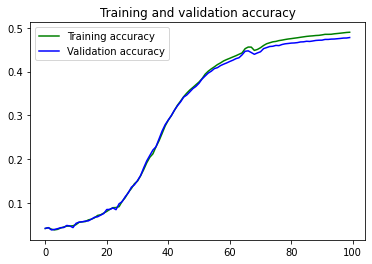

<Figure size 432x288 with 0 Axes>

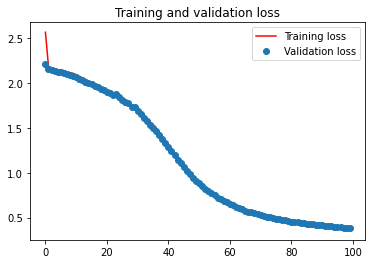

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig('wordA.png')
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'o', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.savefig('wordL.png')
plt.figure()
plt.show()

In [ ]:
from tensorflow import keras
from keras.models import load_model
from keras.layers import Input, LSTM, Dense
from keras.models import Model
#training_model = load_model('/content/drive/My Drive/MachineTranslation/training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, encoder_states)

latent_dim = 256
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_response(test_input):
    #Getting the output states to pass into the decoder
    states_value = encoder_model.predict(test_input)
    #Generating empty target sequence of length 1
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Setting the first token of target sequence with the start token
    target_seq[0, 0, target_features_dict['<START>']] = 1.
    
    #A variable to store our response word by word
    decoded_sentence = ''
    
    stop_condition = False
    while not stop_condition:
      #Predicting output tokens with probabilities and states
      output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)
#Choosing the one with highest probability
      sampled_token_index = np.argmax(output_tokens[0, -1, :])
      sampled_token = reverse_target_features_dict[sampled_token_index]
      decoded_sentence += " " + sampled_token
#Stop if hit max length or found the stop token
      if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
        stop_condition = True
#Update the target sequence
      target_seq = np.zeros((1, 1, num_decoder_tokens))
      target_seq[0, 0, sampled_token_index] = 1.
      #Update states
      states_value = [hidden_state, cell_state]
    return decoded_sentence

In [ ]:
class Translator:
  exit_commands = ("quit", "pause", "exit", "goodbye", "bye", "later", "stop")
  
  #Method to start the translator
  def start(self):
    user_response = input("Give in an English sentence. :) \n")
    self.translate(user_response)
  
  #Method to handle the conversation
  def translate(self, reply):
    while not self.make_exit(reply):
      reply = input(self.generate_response(reply)+"\n")
#Method to convert user input into a matrix
  def string_to_matrix(self, user_input):
    tokens = re.findall(r"[\w']+|[^\s\w]", user_input)
    user_input_matrix = np.zeros(
      (1, max_encoder_seq_length, num_encoder_tokens),
      dtype='float32')
    for timestep, token in enumerate(tokens):
      if token in input_features_dict:
        user_input_matrix[0, timestep, input_features_dict[token]] = 1.
    return user_input_matrix
  
  #Method that will create a response using seq2seq model we built
  def generate_response(self, user_input):
    input_matrix = self.string_to_matrix(user_input)
    chatbot_response = decode_response(input_matrix)
    #Remove <START> and <END> tokens from chatbot_response
    chatbot_response = chatbot_response.replace("<START>",'')
    chatbot_response = chatbot_response.replace("<END>",'')
    return chatbot_response
  
  #Method to check for exit commands
  def make_exit(self, reply):
    for exit_command in self.exit_commands:
      if exit_command in reply:
        print("Ok, have a great day!")
        return True
    return False
  
translator = Translator()

In [ ]:
translator.start()

Give in an English sentence. :) 
i like bananas
1/1 [==============================] - 0s 15ms/step
 म ै ं क े ल े क ो न ा पस ं द करत ी ह ै । 
she likes peaches
1/1 [==============================] - 0s 18ms/step
 वह स े ब और स ं पस ं द करत ी ह ै । 
exit
Ok, have a great day!
